In [1]:
%matplotlib inline 
import os
import ee
from ee import batch
import time
import requests
import zipfile
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import rasterio as rio
from rasterio.windows import from_bounds, Window
from rasterio.warp import reproject
from rasterio.enums import Resampling, ColorInterp
import datetime
import pandas as pd

# Trigger the authentication flow.
# ee.Authenticate()
# Initialize the library.
ee.Initialize()

# functions for pansharpening

In [2]:
def calculateRatio(rgb, pan, weight):
    return pan / ((rgb[0] + rgb[1] + rgb[2] * weight) / (2 + weight))

def Brovey(rgb, pan, weight, pan_dtype):
    with np.errstate(invalid='ignore', divide='ignore'):
        ratio = calculateRatio(rgb, pan, weight)
    with np.errstate(invalid='ignore'):
        sharp = np.clip(ratio * rgb, 0, np.iinfo(pan_dtype).max)
        return sharp.astype(pan_dtype), ratio
    
def _upsample(rgb, panshape, src_aff, src_crs, to_aff, to_crs):
    up_rgb = np.empty((rgb.shape[0], panshape[0],panshape[1]), dtype=rgb.dtype)
    reproject(rgb, up_rgb,src_transform=src_aff,src_crs=src_crs,dst_transform=to_aff,
              dst_crs=to_crs,resampling=Resampling.bilinear)
    return up_rgb

def _create_apply_mask(rgb):
    color_mask = np.all(np.rollaxis(rgb, 0, 3) != 0,axis=2).astype(np.uint16) * np.iinfo(np.uint16).max
    masked_rgb = np.array([np.minimum(band, color_mask) for band in rgb])
    return masked_rgb

def pansharpen(vis, vis_transform, pan, pan_transform, pan_dtype, r_crs, dst_crs, weight=0.2, method="Brovey", src_nodata=0):
    rgb = _upsample(_create_apply_mask(vis), pan.shape, vis_transform, r_crs, pan_transform, dst_crs)
    # Main Pansharpening Processing
    if method == "Brovey":
        pansharp, _ = Brovey(rgb, pan, weight, pan_dtype)
    # TODO: add other methods
    return pansharp

def add_years(d, years):
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        if years < 0:
            return d + (datetime.date(d.year + years, 3, 1) - datetime.date(d.year, 3, 1))
        else:
            return d + (datetime.date(d.year + years, 1, 1) - datetime.date(d.year, 1, 1))

# Landsat 8 Band info

In [3]:
band_info = {'B1': {'name':'Coastal aerosol','wavelength':'0.43 - 0.45 µm', 'resolution':'30 meters'}, 
             'B2': {'name':'Blue','wavelength':'0.45 - 0.51 µm', 'resolution':'30 meters'}, 
             'B3': {'name':'Green','wavelength':'0.53 - 0.59 µm', 'resolution':'30 meters'},
             'B4': {'name':'Red','wavelength':'0.64 - 0.67 µm', 'resolution':'30 meters'},
             'B5': {'name':'Near Infrared (NIR)','wavelength':'0.85 - 0.88 µm', 'resolution':'30 meters'},
             'B6': {'name':'SWIR 1','wavelength':'1.57 - 1.65 µm', 'resolution':'30 meters'},
             'B7': {'name':'SWIR 2','wavelength':'2.11 - 2.29 µm', 'resolution':'30 meters'},
             'B8': {'name':'Panchromatic','wavelength':'0.52 - 0.90 µm', 'resolution':'30 meters'},
             'B9': {'name':'Cirrus','wavelength':'1.36 - 1.38 µm', 'resolution':'30 meters'},
             'B10': {'name':'Thermal Infrared (TIRS) 1','wavelength':'10.60 - 11.19 µm', 'resolution':'100 meters'},
             'B11': {'name':'Thermal Infrared (TIRS) 2','wavelength':'11.50 - 12.51 µm', 'resolution':'100 meters'},
             'BQA': {'name':'Quality Assessment','wavelength':'n/a', 'resolution':'n/a'}}

# doline info

In [26]:
equalize_bands = False

In [27]:
n_scenes_before_after = 5
equalize_bands = True # wether to plot all bands for each doline on same range of values

download_folder_zip = 'tmp_downloads_zip/'
download_folder_scenes = 'ee_test_downloads/'

doline_id = '%03d' % 1
lower_lim = '2019-06-09'
upper_lim = '2019-06-11'
center_lat = -72.3474
center_lon = 67.64577
shelf = 'Amery'
print('Doline ' + doline_id)

dateformat = '%Y-%m-%d'
lower_time = datetime.datetime.strptime(lower_lim, dateformat)
upper_time = datetime.datetime.strptime(upper_lim, dateformat)
search_start = add_years(lower_time, years=-1).strftime(dateformat)
search_end = add_years(upper_time, years=1).strftime(dateformat)

center_lonlat = [center_lon,center_lat]
poi = ee.Geometry.Point(center_lonlat[0],center_lonlat[1])
roi = poi.buffer(3000)
# collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \ # doesn't see to be avialable
collection = ee.ImageCollection('LANDSAT/LC08/C01/T2') \
    .filterDate(search_start, search_end) \
    .filterBounds(poi)
n_imgs = collection.size().getInfo()
# print('number of images: %d' % n_imgs)
info = collection.getInfo()

# get all the scenes to be downloaded (n_scenes_before_after around the estimated timeframe of formation)
times, timestrings, prodIDs, scenenames, crss = [], [], [], [], []
for i in range(n_imgs):
    times.append(datetime.datetime.strptime(info['features'][i]['properties']['DATE_ACQUIRED'],dateformat))
    timestrings.append(info['features'][i]['properties']['DATE_ACQUIRED'])
    prodIDs.append(info['features'][i]['properties']['LANDSAT_PRODUCT_ID'])
    scenenames.append(info['features'][i]['id'])
    crss.append(info['features'][i]['bands'][1]['crs'])
timearray = np.array(times)
timedf = pd.DataFrame({'iScene': np.arange(n_imgs), 
                       'date': timearray,
                       'product_id': prodIDs,
                       'scene_name': scenenames,
                       'crs': crss,
                       'date_string': timestrings})
pd.options.mode.chained_assignment = None
timedf['between'] = (timedf.date > lower_time) & (timedf.date < upper_time)
timedf['before_lower'] = lower_time-timedf.date 
timedf.loc[timedf['before_lower'] < datetime.timedelta(0), 'before_lower'] = datetime.timedelta(99999)
timedf['after_upper'] = timedf.date-upper_time
timedf.loc[timedf['after_upper'] < datetime.timedelta(0), 'after_upper'] = datetime.timedelta(99999)
timedf[['before','after']] = False
timedf.sort_values(by='after_upper',ascending=True,inplace=True)
timedf.iloc[:n_scenes_before_after]['after'] = True
timedf.sort_values(by='before_lower',ascending=True,inplace=True)
timedf.iloc[:n_scenes_before_after]['before'] = True
scenedf = timedf[(timedf.between | timedf.before | timedf.after)]
scenedf.drop(columns=['between', 'before', 'after', 'before_lower', 'after_upper'],inplace=True)
scenedf.sort_values('date', ascending=True, inplace=True)
scenedf.reset_index(drop=True,inplace=True)

Doline 001


In [28]:
# download all the data
print('  downloaded scene (of %d)' % (len(scenedf.iScene)), end=' --> ')
for j, iScene in enumerate(scenedf.iScene):
    sceneName = scenedf.scene_name.iloc[j]
    thisScene = ee.Image(sceneName)
    fn = scenedf.product_id.iloc[j]
    downloadURL = thisScene.getDownloadUrl({
                    'name': fn,
                    'bands':[{'id':'B1','scale':30},
                             {'id':'B2','scale':30},
                             {'id':'B3','scale':30},
                             {'id':'B4','scale':30},
                             {'id':'B5','scale':30},
                             {'id':'B6','scale':30},
                             {'id':'B7','scale':30},
                             {'id':'B8','scale':15},
                             {'id':'B9','scale':30},
                             {'id':'B10','scale':100},
                             {'id':'B11','scale':100}],
                    'crs': scenedf.crs.iloc[j],
                    'region': roi})

    response = requests.get(downloadURL)
    
    if not os.path.exists(download_folder_zip): os.makedirs(download_folder_zip)
    with open(download_folder_zip+fn+'.zip', 'wb') as fd:
        fd.write(response.content)

    with zipfile.ZipFile(download_folder_zip+fn+'.zip',"r") as zip_ref:
        zip_ref.extractall(download_folder_scenes)
        
    print('%d'%j,end=' ')
print(' ')

  downloaded scene (of 10) --> 0 1 2 3 4 5 6 7 8 9  


In [29]:
# get the max/min values across all scenes for each band
band_list = list(band_info.keys())[:-1]
data_mins_list = {k: [] for k in band_list}
data_maxs_list = {k: [] for k in band_list}
for fn in scenedf.product_id:
    for i in range(11):
        im = rio.open('%s%s.B%d.tif' % (download_folder_scenes,fn,i+1))
        imarray = im.read(1)
        data_mins_list[band_list[i]].append(imarray[imarray>0].min())
        data_maxs_list[band_list[i]].append(imarray[imarray>0].max())
data_mins_dict = {k: np.mean(data_mins_list[k]) for k in band_list}
data_maxs_dict = {k: np.mean(data_maxs_list[k]) for k in band_list}

  plotted scene (of 10) --> 0 1 2 3 4 5 6 7 8 9  


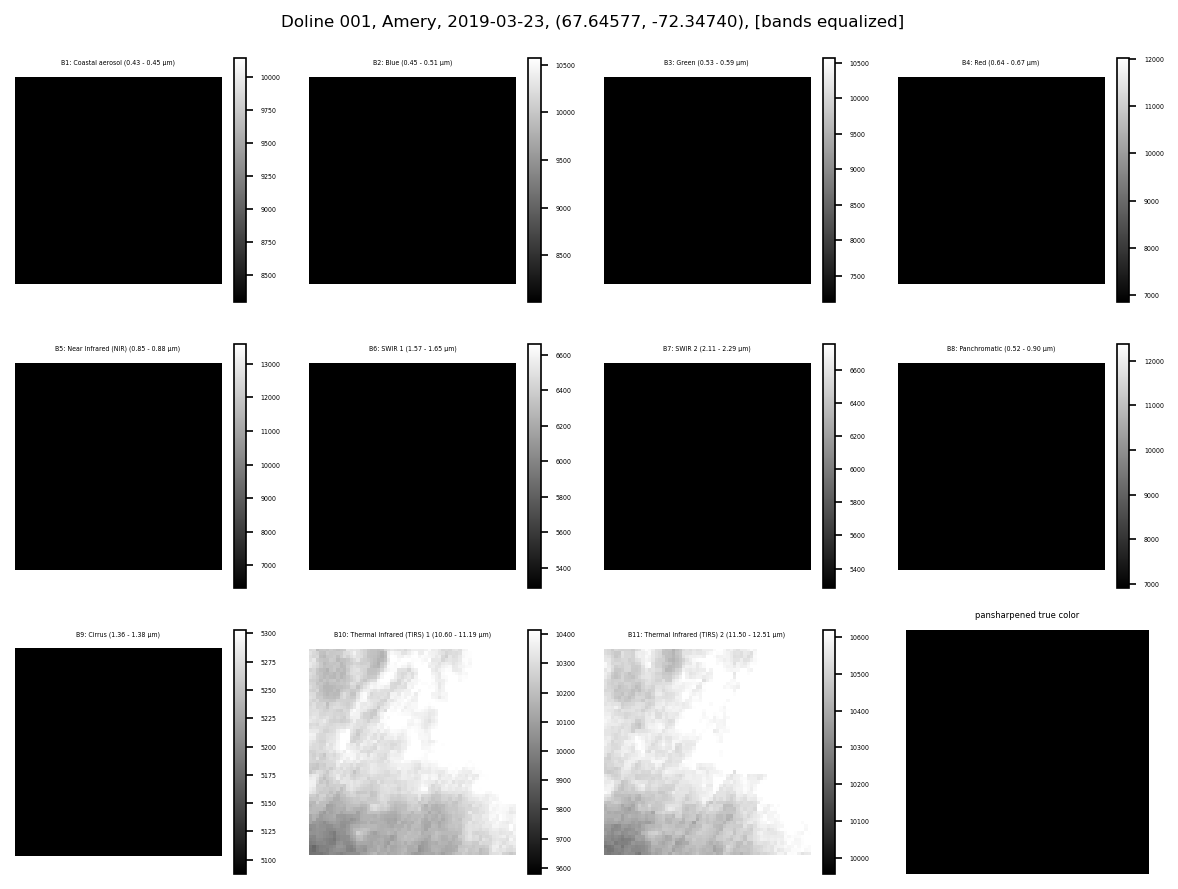

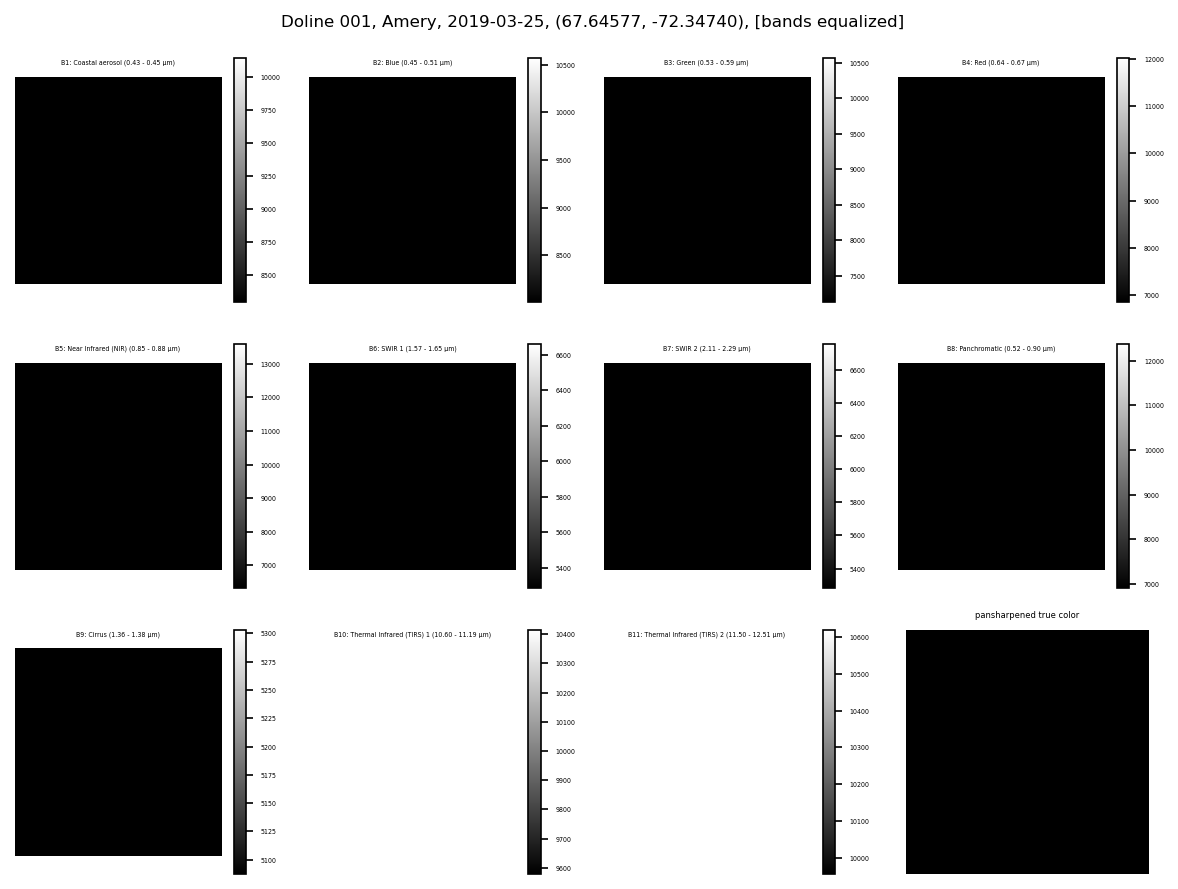

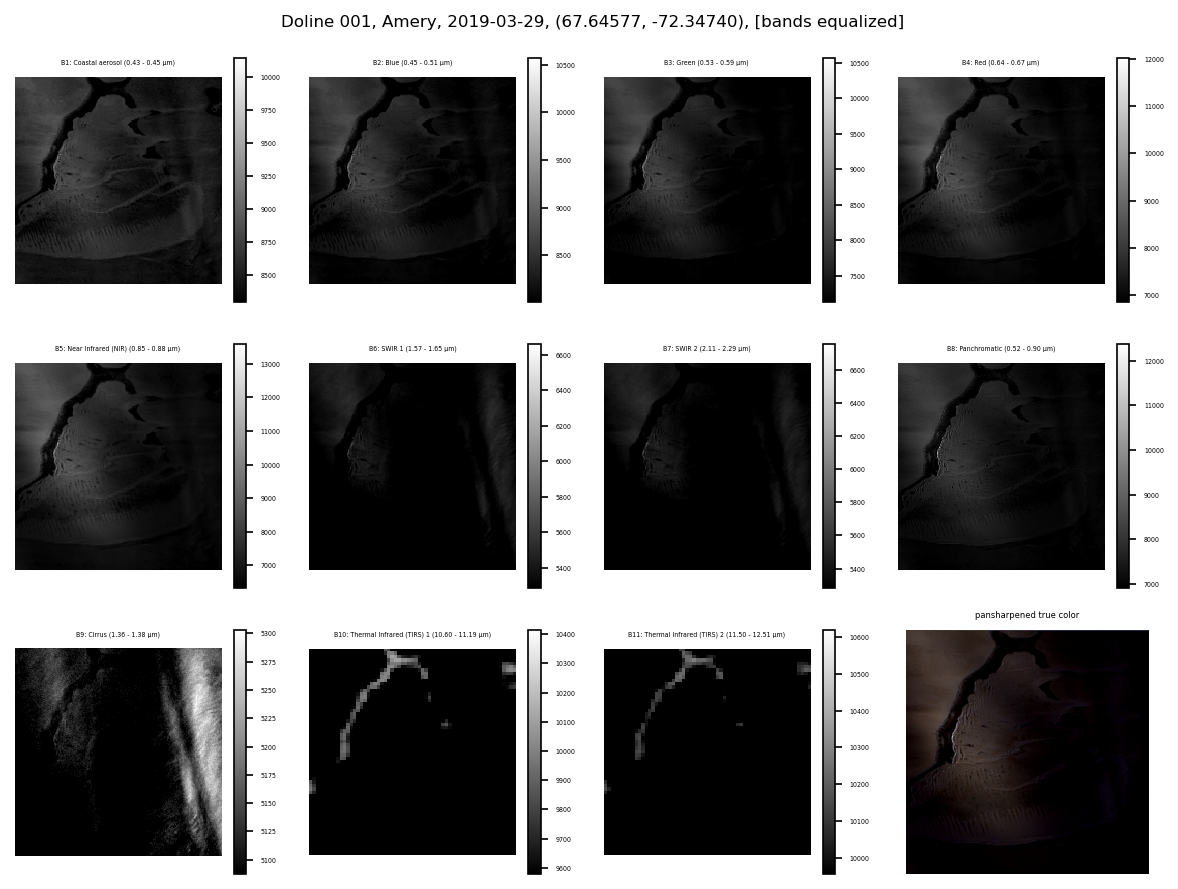

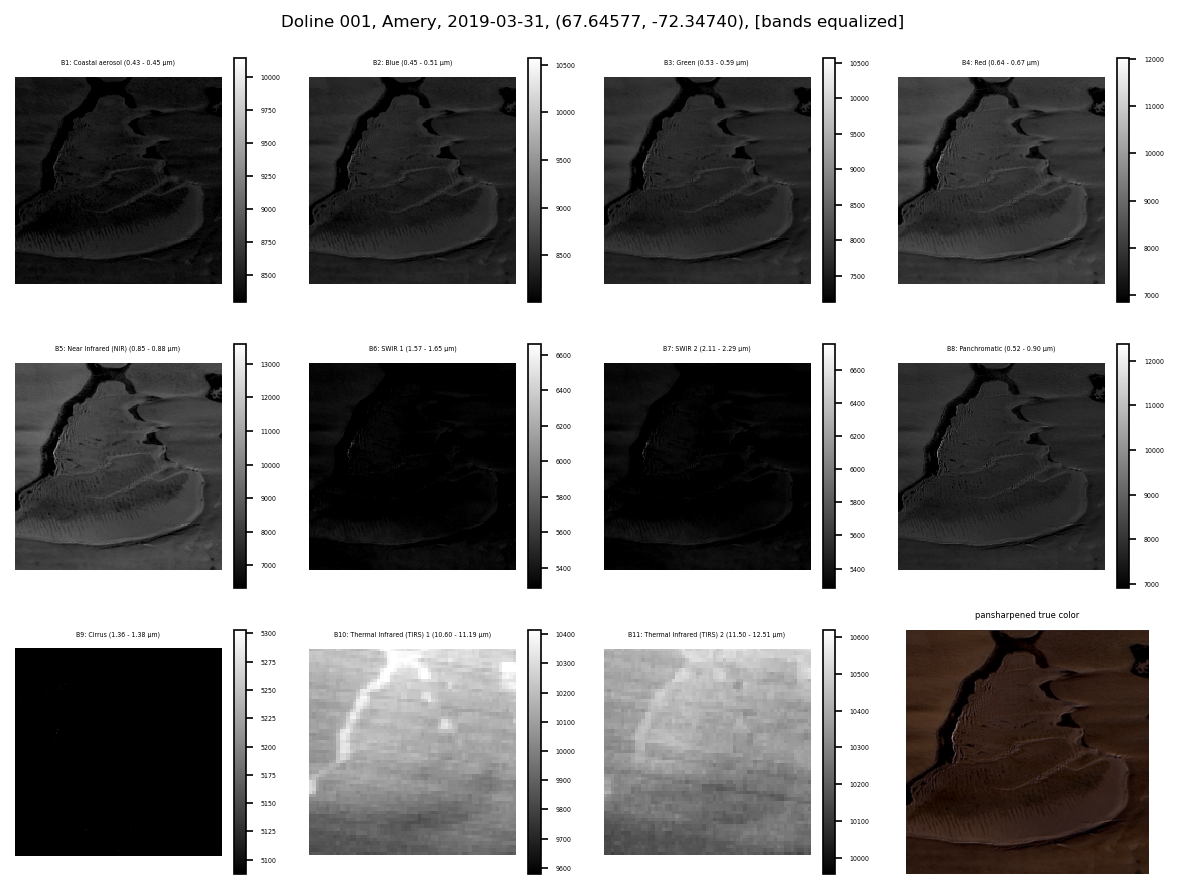

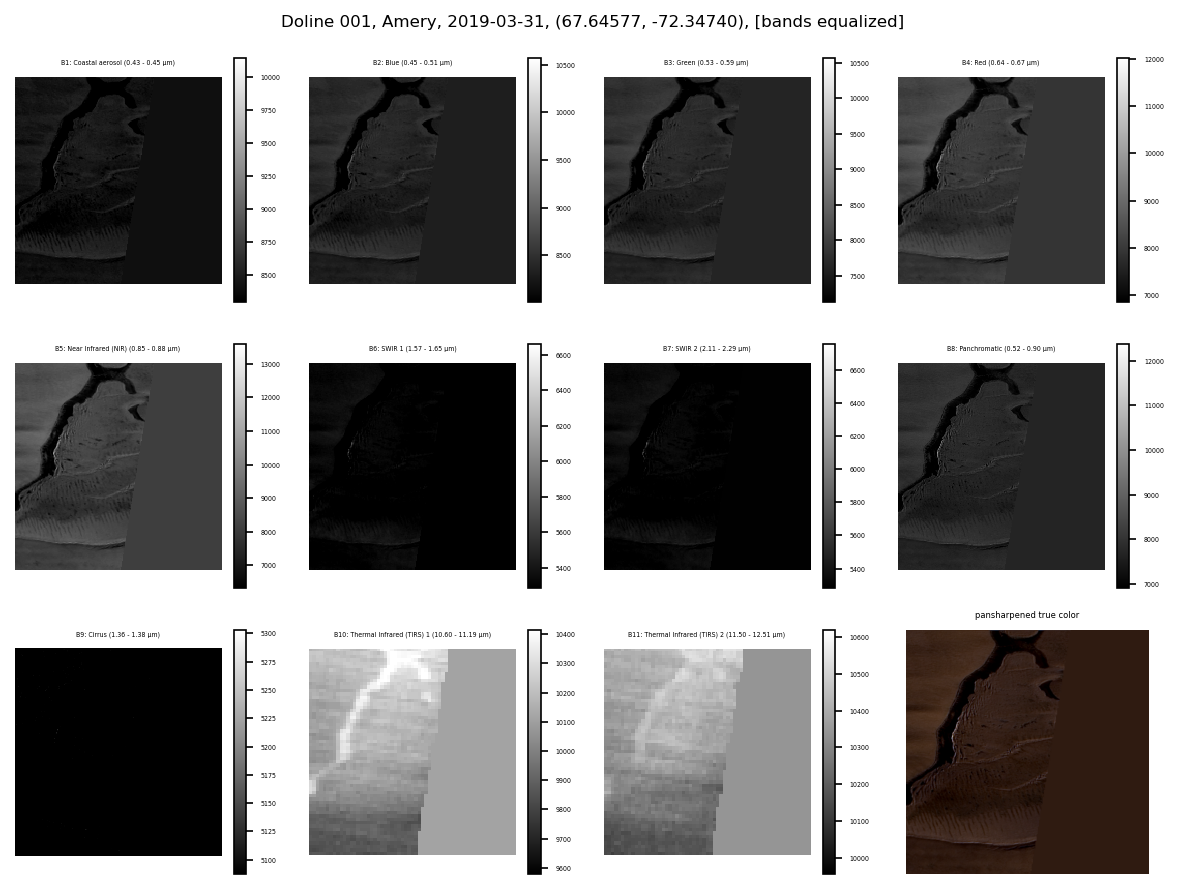

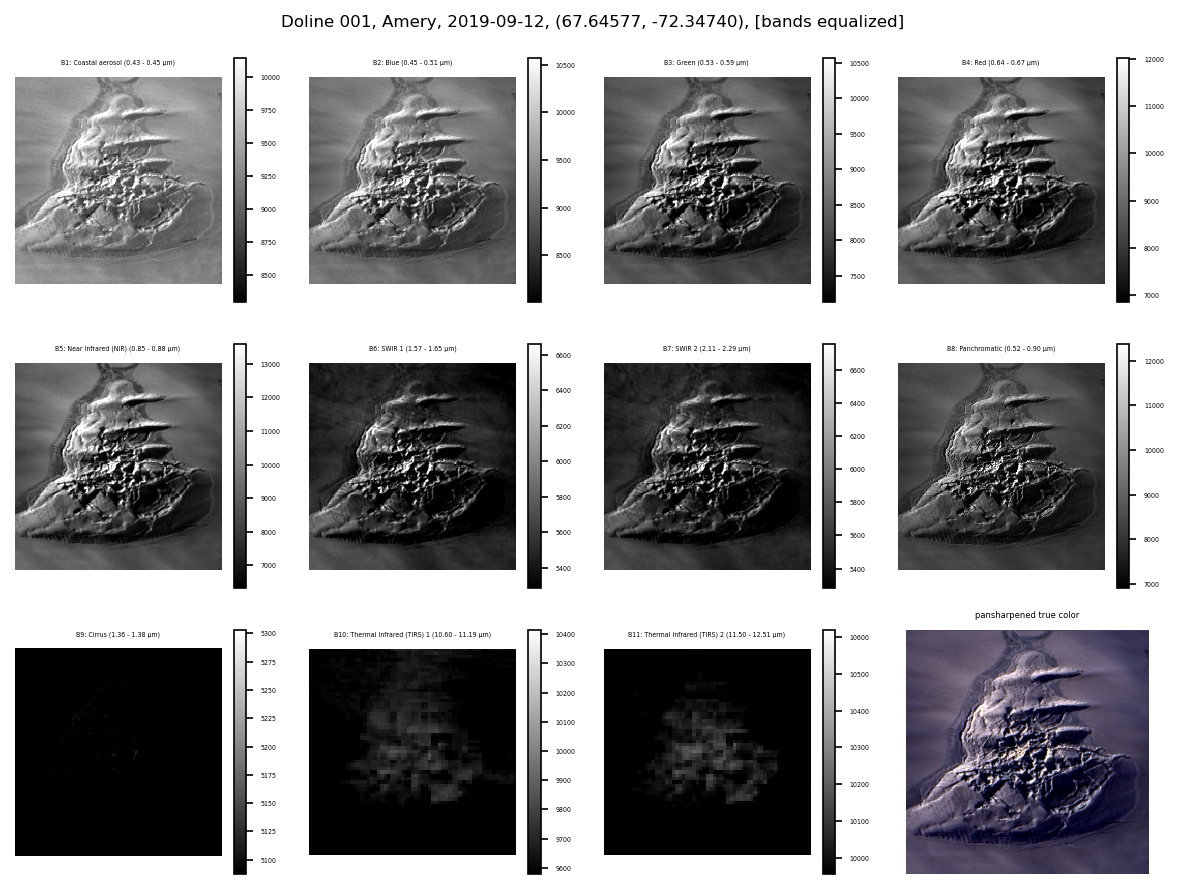

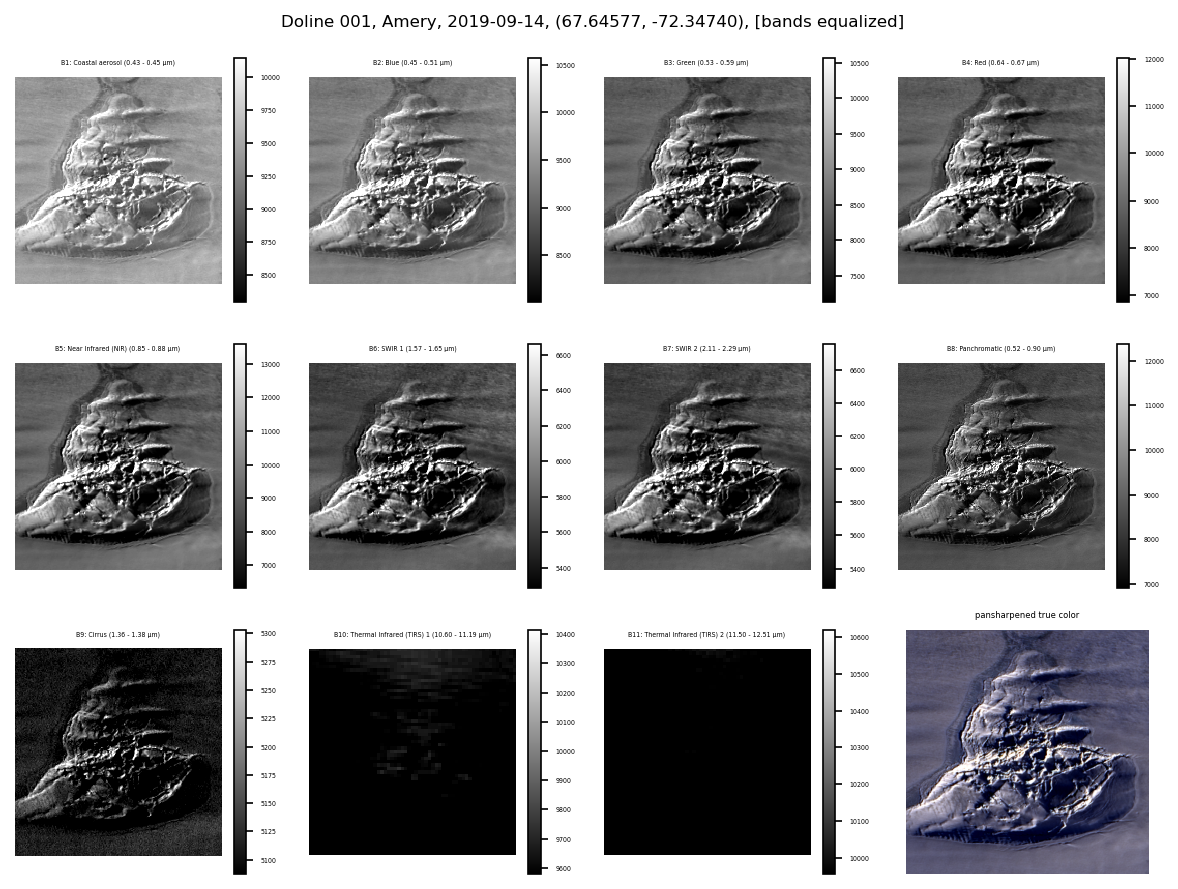

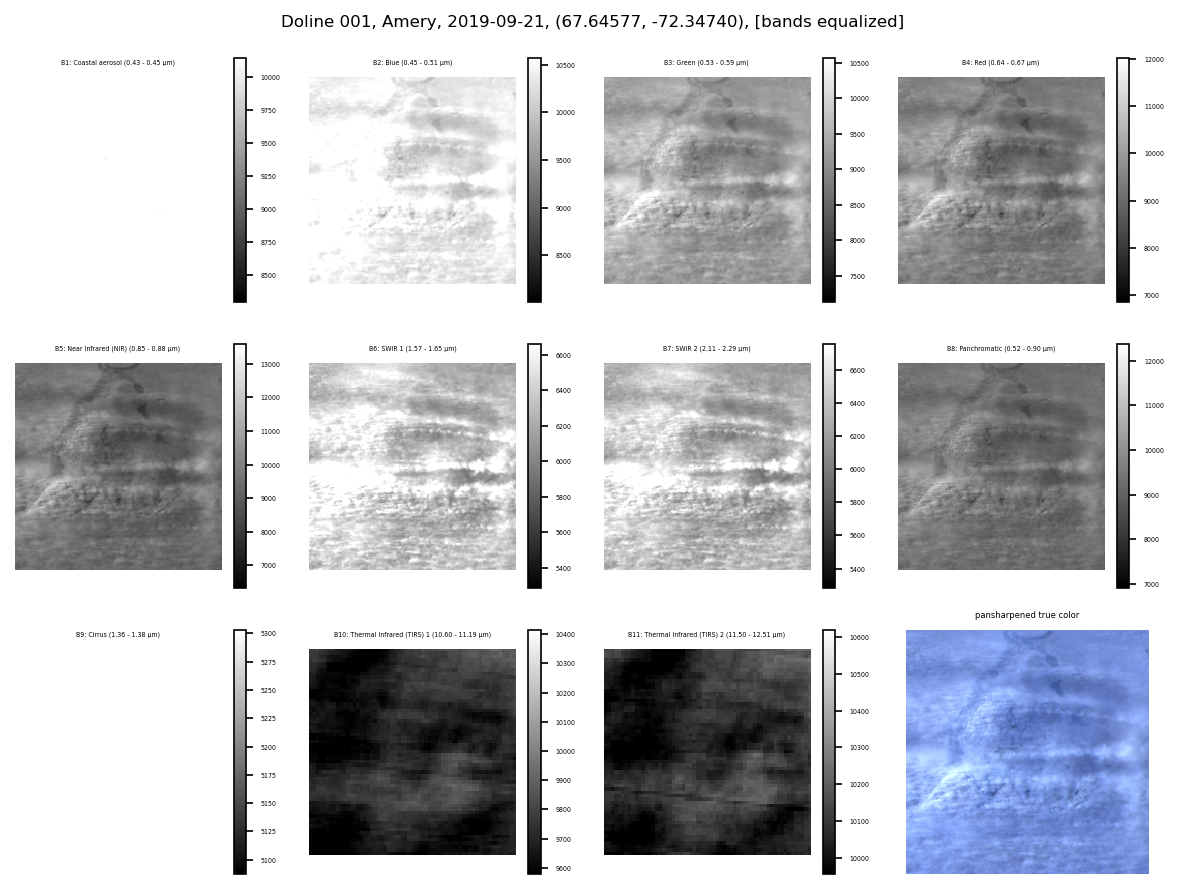

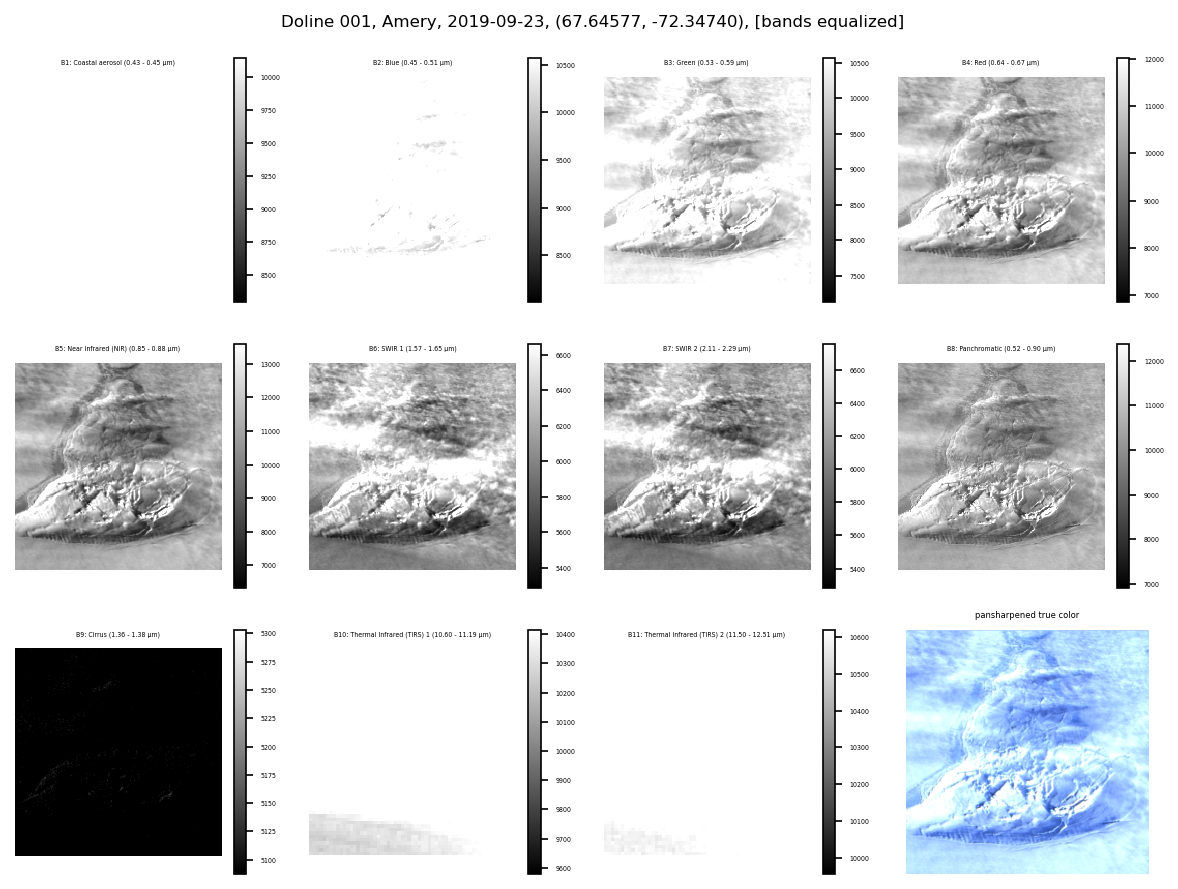

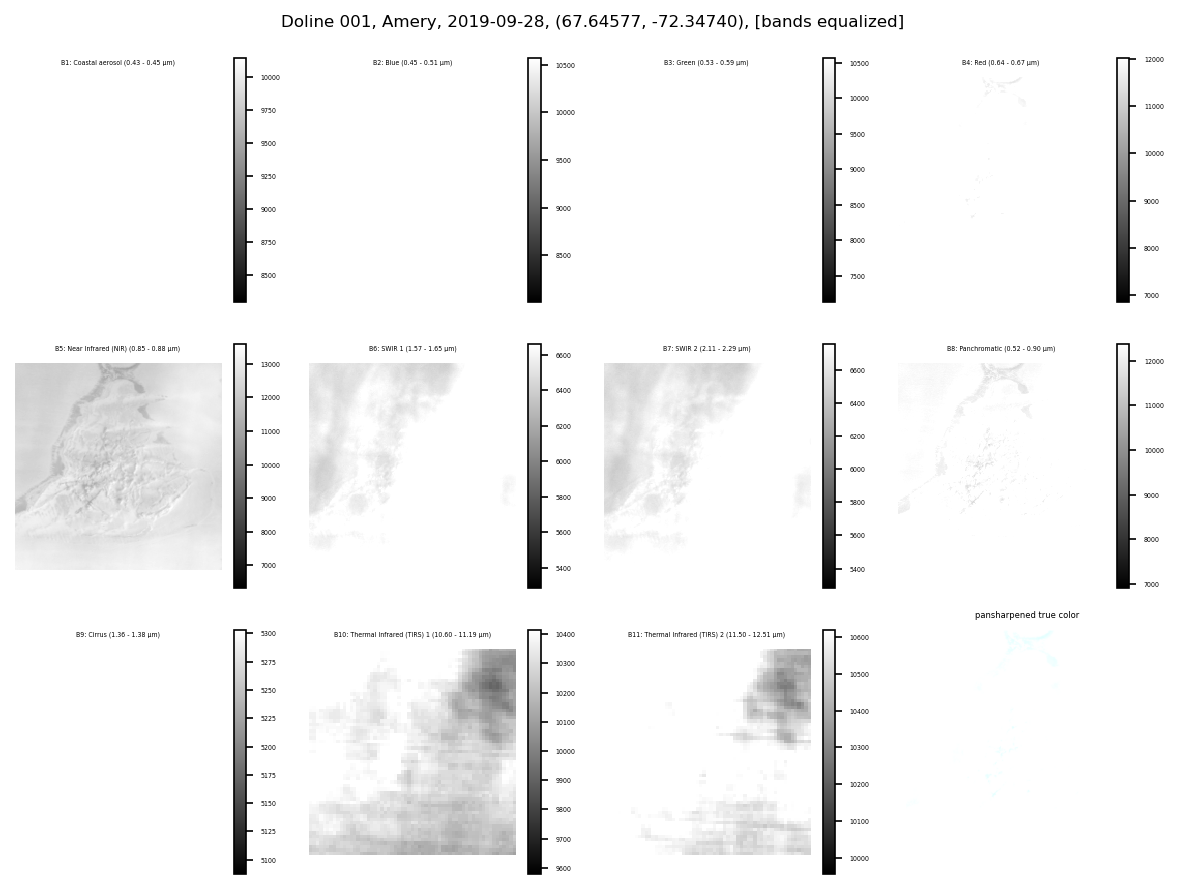

In [32]:
# make the plots
print('  plotted scene (of %d)' % (len(scenedf.iScene)), end=' --> ')
for j, fn in enumerate(scenedf.product_id):
    fig = plt.figure(figsize=[8,6],dpi=150)
    for i in range(11):
        ax = fig.add_subplot(3,4,i+1)
        im = rio.open('%s%s.B%d.tif' % (download_folder_scenes,fn,i+1))
        imarray = im.read(1)
        imarray[imarray==0] = np.mean(imarray[imarray!=0])
        vmin = data_mins_dict[band_list[i]]
        vmax = data_maxs_dict[band_list[i]]
        if equalize_bands:
            implot = ax.imshow(imarray, interpolation='nearest',cmap='gray',vmin=vmin,vmax=vmax)
        else:
            thismin = np.mean(imarray)-3*np.std(imarray)
            thismax = np.mean(imarray)+3*np.std(imarray)
            implot = ax.imshow(imarray, interpolation='nearest',cmap='gray',vmin=thismin,vmax=thismax)
        cbar = fig.colorbar(implot,ax=ax)
        cbar.ax.tick_params(labelsize=3) 
        ax.axis('off')
        band_id = list(band_info.keys())[i]
        band_name = band_info[band_id]['name']
        band_wl = band_info[band_id]['wavelength']
        ax.set_title('%s: %s (%s)'%(band_id,band_name,band_wl),fontsize=3)
    
    # this is for the pansharpened rgb composite
    ax = fig.add_subplot(3,4,12)
    r = rio.open('%s%s.B%d.tif' % (download_folder_scenes,fn,4))
    g = rio.open('%s%s.B%d.tif' % (download_folder_scenes,fn,3))
    b = rio.open('%s%s.B%d.tif' % (download_folder_scenes,fn,2))
    p = rio.open('%s%s.B%d.tif' % (download_folder_scenes,fn,8))
    pan = p.read(1)
#     vis = []
#     for i,vband in enumerate([r,g,b]):
#         vis.append(vband.read(1))
#     vis = np.stack(vis,axis=2)
    vis = np.zeros(shape=(3,r.height,r.width))
    for i,vband in enumerate([r,g,b]):
        vis[i,:,:] = vband.read(1)
    pan_transform = p.transform
    vis_transform = r.transform
    pansharpened = pansharpen(vis=vis, vis_transform=vis_transform, pan=pan, pan_transform=pan_transform,
                              pan_dtype=pan.dtype, r_crs=r.crs, dst_crs=p.crs)
    data = []
    for i,bandid in enumerate(['B4','B3','B2']):
        imarray = pansharpened[i]
        imarray[imarray==0] = np.mean(imarray[imarray!=0])
        vmin = data_mins_dict[bandid]
        vmax = data_maxs_dict[bandid]
        if equalize_bands:
            imarray = np.uint8(np.clip(np.round((imarray-vmin) / (vmax-vmin) * 255),0,255))
        else:
            # imarray = np.uint8(np.round((imarray-np.min(imarray)) / (np.max(imarray)-np.min(imarray)) * 255))\
            thismin = np.mean(imarray)-3*np.std(imarray)
            thismax = np.mean(imarray)+3*np.std(imarray)
            imarray = np.uint8(np.clip(np.round((imarray-thismin) / (thismax-thismin) * 255),0,255))
        data.append(imarray)
    rgb = np.stack(data,axis=2)

    implot = ax.imshow(rgb)
    ax.axis('off')
    ax.set_title('pansharpened true color',fontsize=4);
    
    equal_title = '[bands equalized]' if equalize_bands else '[bands not equalized]'
    fig.suptitle('Doline %s, %s, %s, (%.5f, %.5f), %s' % (doline_id, 
                                                          shelf, 
                                                          scenedf.date_string.iloc[j], 
                                                          center_lon, 
                                                          center_lat, 
                                                          equal_title),fontsize=8)
    fig.tight_layout()
    fig_dir = 'figs/'
    if not os.path.exists(fig_dir): os.makedirs(fig_dir)
    equal_str = 'equalized' if equalize_bands else 'not-equalized'
    figname = 'figs/doline_%s_%s_%s_%s.jpg' % (doline_id,equal_str,scenedf.date_string.iloc[j],scenedf.product_id.iloc[j])
    plt.savefig(figname, dpi=600)
    # plt.close()
    
    print('%d'%j,end=' ')
    
print(' ')

# ==========================================
# for exporting figures to zip

In [17]:
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

zipfigfolder = 'zipped_figs/'
if not os.path.exists(zipfigfolder): os.makedirs(zipfigfolder)
zipf = zipfile.ZipFile(zipfigfolder+'figures_%s.zip'%datetime.datetime.now().strftime("%Y-%m-%d_%H-%M"), 'w', zipfile.ZIP_DEFLATED)
zipdir(fig_dir, zipf)
zipf.close()

# ==========================================